## The dataset

Here I will introduce the dataset, experiment with it, tokenize it, preprocess it and save it to a new set of files.

In [407]:
import codecs
import numpy as np
f_fr = codecs.open("DATA/en-fr_paropt/dev.tok.fr", encoding='utf-8')
f_en = codecs.open("DATA/en-fr_paropt/dev.tok.en", encoding='utf-8')
text_fr = f_fr.read()
text_en = f_en.read()
print text_en[0:1000]
print len(text_en.split('\n'))
print len(text_fr.split('\n'))

It was Nov . 10 of last year when stagehand Kevin Monk , his kindergarten-teacher wife , Roseanna , and Genevieve were getting ready to go on a family trip .
The beginning of a new era means a problem for all Christian democracy , including Angela Merkel as well .
Obama ? The first anti-American President . Here is why ?
While villages report a sharp decline in interest in driver &apos;s license renewal , the authorities in the city are overloaded with applications and the interest in the license renewal has grown this week .
Internet use is extremely limited on the island .
On November 4th the lophoscopist of Cali CTI passed into history as the man who confirmed the identity of the FARC top leader , &quot; Alfonso Cano , through the comparison of his fingerprints .
Both teams found it difficult to join in the combination ; the game remained around the mid-field line most of the time .
The researchers put a small bucket with a moth larva in a vertical cylinder .
&quot; It &apos;s like 

# Tokenizing and preprocessing
Here we can see that sentences are not really split over lines since "Here is why ?" is technically it's own sentence - however, splitting these cases up will lead to misalignment between the english and french corpora so it's too risky. What I will do then is just tokenize each line, remove capitalisation and then replace the final punctuation with `<EOS` and unknown characters with `<UNK>` or `1`.

In [408]:
# Fix a small pathology with the datasets, whereby spaces are put between words
# and end of sentence tokens
def format_eos(text):
    #text = text.replace(' .', '.')
    #text = text.replace('?')
    #text = text.replace('!', '.')
    #text = text.replace("didn &apos;t", 'did not')
    #text = text.replace("shouldn &apos;t", 'should not')
    return text

#text_fr = format_eos(text_fr)
#text_en = format_eos(text_en)
print "still aligned:", len(text_en.split('\n')) == len(text_fr.split('\n'))

still aligned: True


In [409]:

import nltk.data
import random
# First split up into lines using the Punkt tokenizer
#fr_sent_detector = nltk.data.load('tokenizers/punkt/french.pickle')
#en_sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
#fr_sents = fr_sent_detector.tokenize(text_fr)
#en_sents = en_sent_detector.tokenize(text_en)

# First split the text up into lines
en_sents = text_en.split('\n')
fr_sents = text_fr.split('\n')
# Randomise the lists but maintain parallel ordering
s = zip(en_sents, fr_sents)
np.random.shuffle(s)
en_sents, fr_sents = zip(*s)
sents_en = en_sents
sents_fr = fr_sents

print "\n".join([sents_en[0],sents_fr[0]])
print "------------"
print "\n".join([sents_en[302],sents_fr[302]])
print "------------\n Judging by keywords and rudimentary knowledge of French, I suspect the corpora are still aligned."
print "corpora still same length:", len(en_sents)== len(fr_sents), '\n'

A year after the Copenhagen agreement it is time to look at the observance of the promises of fast finance ( so-called fast start finance ) by developed countries .
Un an après l&apos; Accord de Copenhague , il est temps d&apos; examiner le respect des promesses de financements rapidement débloqués ( dits financements fast start ou précoces ) réalisés par les pays développés .
------------
Of course , as sources in the financial community point out , negotiations have only just begun .
Les pourparlers viennent cependant seulement de commencer , dit-on dans la place financière .
------------
 Judging by keywords and rudimentary knowledge of French, I suspect the corpora are still aligned.
corpora still same length: True 



In [410]:
# Next split up into tokens using the toktok tokenizer
from nltk.tokenize import toktok
tok_tokenizer = toktok.ToktokTokenizer()

def tokenize_sentences(text):
    new_text = []
    for sentence in text:
        # This splits up tokens within a sentence
        tok_sent = tok_tokenizer.tokenize(sentence.lower())
        # I'm keeping the final punctuation and appending the 
        # <EOS> tag after it
        new_text.append(tok_sent+[u'<EOS>'])
    return new_text
print tokenize_sentences(sents_en[0:3])
tokenized_en = tokenize_sentences(sents_en)
tokenized_fr = tokenize_sentences(sents_fr)

[[u'a', u'year', u'after', u'the', u'copenhagen', u'agreement', u'it', u'is', u'time', u'to', u'look', u'at', u'the', u'observance', u'of', u'the', u'promises', u'of', u'fast', u'finance', u'(', u'so-called', u'fast', u'start', u'finance', u')', u'by', u'developed', u'countries', u'.', u'<EOS>'], [u'when', u'the', u'group', u'began', u'to', u'play', u'live', u',', u'it', u'became', u'leningrad', u'.', u'<EOS>'], [u'&quot', u';', u'if', u'a', u'static', u'table', u'which', u'warns', u'against', u'danger', u'is', u'installed', u',', u'it', u'will', u'likely', u'soon', u'blend', u'in', u'with', u'the', u'surroundings', u'and', u'the', u'drivers', u'will', u'not', u'pay', u'attention', u'to', u'it', u',', u'&quot', u';', u'ko\u0159\xe1n', u'warned', u'.', u'<EOS>']]


## Vocabularies, Sequences and Word frequencies

I need to:
- Find the frequencies of words, limiting the vocabulary size to some number of the most common words and replacing out of vocabulary words with `<UNK>`
- Give each token an ID, where `<EOS>` =0, `<UNK>` =1 and the remaining tokens are assigned numbers from 2 to vocab_size+1 at random
- Make each sequence the same length by padding the end of sequences with zeros until their length matches the longest sequence. Given the long-tailed distribution of sequence length and the limited capacity of LSTMs we may be able to truncate max sequence length substantially.


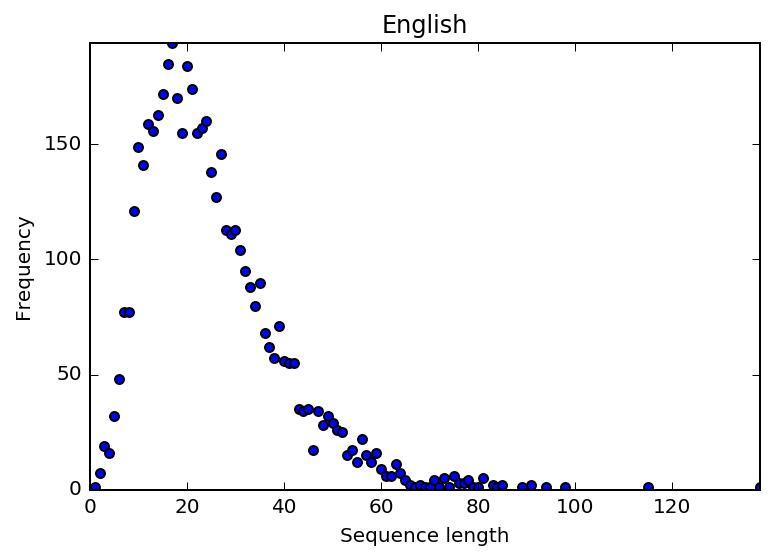

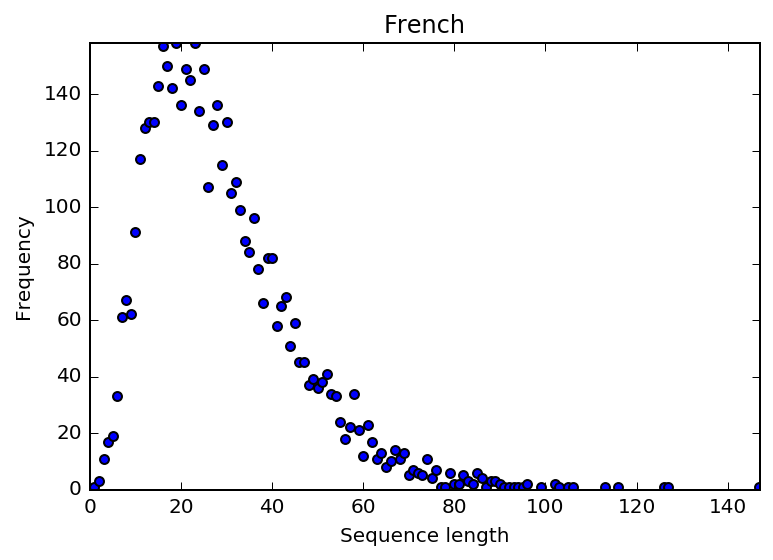

English vocab size restricts to 7.33568075117 percent of total vocab.
Percentage of whole English corpus covered by vocab: 76.0516024995
French vocab size restricts to 6.16180910715 percent of total vocab.
Percentage of whole French corpus covered by vocab: 76.7572438652


In [411]:
import nltk
import matplotlib.pyplot as plt

def seq_length_stats(tokenized_text, lang='English'):
    seq_data = dict()
    for sublist in tokenized_text:
        # Need to keep track of the longest sequence length to pad shorter ones with <EOS>
        if len(sublist) not in seq_data.keys():
            seq_data[len(sublist)] = 1
        else:
            seq_data[len(sublist)] += 1
    
    plt.scatter(seq_data.keys(), seq_data.values())
    plt.ylim(0, max(seq_data.values()))
    plt.xlim(0, max(seq_data.keys()))
    plt.xlabel("Sequence length")
    plt.ylabel("Frequency")
    plt.title(lang)
    plt.show()
    
    return seq_data, max(seq_data.values())

def replace_with_word_id(tokenized_text, vocab_size, longest_sequence=1, lang='English'):
    '''
    take the list of lists, find FreqDist, replace any
    out of vocabulary words with <UNK> whilst giving each
    token a numerical ID, return new list of lists'''
    flat = []
    max_len = 0
    for sublist in tokenized_text:
        # Need to keep track of the longest sequence length to pad shorter ones with <EOS>
        if len(sublist)>max_len:
            max_len = len(sublist)
        for item in sublist:
            flat.append(item)
    freq = nltk.FreqDist(flat)
    print "{} vocab size restricts to {} percent of total vocab.".format(lang, 100*(float(vocab_size)/len(set(flat))))
    vocab = dict(freq.most_common(vocab_size+1))
    covered_with_vocab = sum(vocab.values())
    del vocab['<EOS>']
    # The identities begin at 2, since <EOS>=1 and <UNK>=2
    word_to_ids = dict([(word, i+2) for i, word in enumerate(vocab.keys())])
    text = []
    total_length = 0
    for sequence in tokenized_text:
        total_length += len(sequence)
        # Make sure sequence is no longer than the maximum allowed
        ids_sent = []
        for token in sequence:
            if token not in vocab.keys():
                if token == '<EOS>':
                    ids_sent.append(1)
                else:
                    ids_sent.append(2)
            else:
                ids_sent.append(word_to_ids[token])
        # Then pad the rest of the sequence with zeros until matches longest_sequence
        text.append(ids_sent)
    print "Percentage of whole {} corpus covered by vocab: {}".format(lang, 
                                            100*(covered_with_vocab/float(total_length)))
    word_to_ids[u'<UNK>'] = 2
    word_to_ids[u'<EOS>'] = 1
    word_to_ids[u'<PAD>'] = 0
    id_to_words = {}
    for word, idx in word_to_ids.items():
        id_to_words[idx] = word
    return text, word_to_ids, id_to_words

en_vocab_size = 1000
fr_vocab_size = 1000

seq_data_en, en_max = seq_length_stats(tokenized_en, lang='English')
seq_data_fr, fr_max = seq_length_stats(tokenized_fr, lang='French')

""" For now, sequences form rows of the matrix, with the number of columns 
    equal to the maximum length of sequence (or timesteps)"""
text_en, vocab_en, id_to_word_en = replace_with_word_id(tokenized_en, 
                                                        en_vocab_size, longest_sequence=en_max, lang='English')

text_fr, vocab_fr, id_to_word_fr = replace_with_word_id(tokenized_fr, 
                                                        fr_vocab_size, longest_sequence=fr_max,  lang='French')

In [412]:
print "Corpora still aligned:", len(text_en) == len(text_fr)
print id_to_word_en.values()[0:20]

Corpora still aligned: True
[u'<PAD>', u'<EOS>', u'<UNK>', u'all', u'chinese', u'issued', u'global', u'focus', u'month', u'four', u'manager', u'higher', u'go', u'children', u'whose', u'paris', u'white', u'young', u'thursday', u'created']


# Word IDs and word-to-vec vectors

Since we are interested in the process of learning weights within the RNNs to predict seq2seq mappings rather than embeddings I have chosen to use pretrained word embeddings ino order to cut down training time. [THis is](https://sites.google.com/site/rmyeid/projects/polyglot#TOC-Download-the-Embeddings) where the embeddings are from.

In [413]:


import pickle
def get_embeddings(id_to_word, lang='en'):
    # We load pretrained word2vec embeddings from polyglot to save on training time
    filename ='DATA/polyglot-'+lang+'.pkl'
    pretrain_vocab, pretrain_embed = pickle.load(open(filename, 'rb'))
    embed_vocab = [pretrain_embed[pretrain_vocab.index('<PAD>')], pretrain_embed[pretrain_vocab.index('</S>')]]
    skip_count = 0
    skipped_words = []
    for idx, word in sorted(id_to_word.items()[2::]):
        try:
            pretrain_idx = pretrain_vocab.index(word)
            embed_vocab.append(pretrain_embed[pretrain_idx])
        except ValueError:
            try:
                # it could be that the word is a name which needs to 
                # be capitalized. Try this...
                pretrain_idx = pretrain_vocab.index(str(word.title()))
                embed_vocab.append(pretrain_embed[pretrain_idx])
            except ValueError:
                try:
                    # it could be that the word is an achronym which needs to 
                    # be upper case. Try this...
                    pretrain_idx = pretrain_vocab.index(word.upper())
                    embed_vocab.append(pretrain_embed[pretrain_idx])
                except ValueError:
                    # Give up trying to find an embedding.
                    # How many words are skipped? Which ones?
                    skip_count +=1
                    skipped_words.append(word)
                    # Let's just initialise the embedding to a random normal distribution
                    embed_vocab.append(np.random.normal(loc=0.0, scale=np.sqrt(2)/4, size=64))
    embed_vocab = np.array(embed_vocab, dtype=np.float32)
    print "The embedding matrix for {} has {} columns and {} rows.".format(lang, 
                                                embed_vocab.shape[0], embed_vocab.shape[1])
    print "{} vocab words were not in the {} embeddings file.".format(skip_count, lang)
    return embed_vocab, skipped_words
# the ith word in words corresponds to the ith embedding 

embed_vocab_en, skipped_en = get_embeddings(id_to_word_en, lang='en')
embed_vocab_fr, skipped_fr = get_embeddings(id_to_word_fr, lang='fr')

The embedding matrix for en has 1002 columns and 64 rows.
27 vocab words were not in the en embeddings file.
The embedding matrix for fr has 1002 columns and 64 rows.
60 vocab words were not in the fr embeddings file.


#### Note: to find a word given an index we use `id_to_word_en` and vice-versa we use `vocab_en`.

In [414]:
print vocab_en['<PAD>'], vocab_en['<EOS>'], vocab_en['<UNK>']
print skipped_en

0 1 2
[u'30', u'25', u'21', u'2011', u'2010', u'2012', u'didn', u'--', u'20', u'2', u'10', u'15', u'14', u'18', u'so-called', u'&quot', u'16', u'100', u'1', u'&apos', u'50', u'5', u'doesn', u'40', u'2007', u'2008', u'12']


** We can see above ** that the English words which were not in the embedding files are fairly specialist words or numerical values (which are the same in French) so hopefully they won't be too much of a problem.

In [415]:
print text_en[0:10]

[[231, 325, 223, 754, 2, 856, 698, 696, 994, 20, 681, 949, 754, 2, 869, 754, 2, 869, 389, 2, 517, 483, 389, 903, 2, 712, 862, 250, 554, 655, 1], [961, 754, 263, 984, 20, 467, 142, 269, 698, 627, 2, 655, 1], [512, 78, 709, 231, 2, 2, 464, 2, 623, 2, 696, 2, 269, 698, 687, 873, 252, 2, 704, 925, 754, 2, 442, 754, 755, 687, 293, 713, 437, 20, 698, 269, 512, 78, 2, 2, 655, 1], [704, 2, 442, 611, 269, 754, 592, 2, 575, 85, 269, 925, 402, 442, 2, 2, 655, 1], [2, 2, 696, 2, 734, 869, 754, 2, 2, 704, 2, 269, 676, 102, 704, 464, 2, 442, 652, 702, 130, 600, 442, 915, 480, 612, 991, 20, 339, 754, 2, 869, 754, 2, 642, 655, 1], [704, 874, 269, 800, 353, 465, 137, 704, 279, 530, 293, 449, 391, 2, 655, 1], [601, 450, 231, 2, 2, 843, 269, 585, 2, 2, 517, 2, 712, 655, 1], [2, 269, 168, 325, 754, 702, 530, 293, 717, 801, 709, 168, 687, 2, 655, 1], [754, 230, 2, 653, 371, 442, 777, 2, 13, 269, 442, 696, 585, 20, 449, 2, 390, 2, 949, 754, 989, 869, 2, 655, 1], [2, 2, 442, 2, 83, 720, 2, 863, 2, 2, 2, 416,

We can see a couple of things:
- The list of lists above does not have consistent lengths of rows (it's not a matrix)
- In order to process large amounts of data we need to break data up into batches of sequences

The format that I need for the seq-to-seq model is a matrix - we do this by padding shorter sequences in a batch with the `<PAD>` token (represented already as the 0th column of the embedding matrix). the of dimension `(max sequence length in batch, batch size)`, so sequences are represented as the columns of the input matrix. 

In [416]:
test_x = [[5,2,3],[2], [4,2], [1,2]]
# it's going to go from the number of cols being the sequence length/ num of rows being batch size
# to the number of rows being the max sequence length/ num cols being batch size
# Essentially like a padding and then transpose
def format_batch(x):
    seq_lengths = [len(row) for row in x]
    n_batches = len(x)
    max_seq_length = max(seq_lengths)
    outputs = np.zeros(shape=(max_seq_length, n_batches),dtype=np.int32)
    for i in range(len(seq_lengths)):
        for j in range(seq_lengths[i]):
            outputs[j][i] = x[i][j]
    return outputs

print format_batch(test_x)
print np.array(format_batch(text_en[0:7]))

[[5 2 4 1]
 [2 0 2 2]
 [3 0 0 0]]
[[231 961 512 704   2 704 601]
 [325 754  78   2   2 874 450]
 [223 263 709 442 696 269 231]
 [754 984 231 611   2 800   2]
 [  2  20   2 269 734 353   2]
 [856 467   2 754 869 465 843]
 [698 142 464 592 754 137 269]
 [696 269   2   2   2 704 585]
 [994 698 623 575   2 279   2]
 [ 20 627   2  85 704 530   2]
 [681   2 696 269   2 293 517]
 [949 655   2 925 269 449   2]
 [754   1 269 402 676 391 712]
 [  2   0 698 442 102   2 655]
 [869   0 687   2 704 655   1]
 [754   0 873   2 464   1   0]
 [  2   0 252 655   2   0   0]
 [869   0   2   1 442   0   0]
 [389   0 704   0 652   0   0]
 [  2   0 925   0 702   0   0]
 [517   0 754   0 130   0   0]
 [483   0   2   0 600   0   0]
 [389   0 442   0 442   0   0]
 [903   0 754   0 915   0   0]
 [  2   0 755   0 480   0   0]
 [712   0 687   0 612   0   0]
 [862   0 293   0 991   0   0]
 [250   0 713   0  20   0   0]
 [554   0 437   0 339   0   0]
 [655   0  20   0 754   0   0]
 [  1   0 698   0   2   0   0]
 [  0

Very cool.

## Evaluation metrics

I am going to use the N-gram BLEU score as my evaluation metric, changing the parameter N to see the effect it has on my model, relative to the benchmark.

## Implementing the BLEU metric
This metric will be used to test how good a prediction actually was.

In [417]:
from nltk.translate import bleu_score

def nonunique_ngrams(phrase, N):
        
        N_grams = {}
        for i in range(len(phrase)):
            li = phrase[i:i+N]
            ng = ' '.join([str(s) for s in li])
            if len(li) == N or len(phrase)<N:
                try:
                    N_grams[ng] += 1
                except KeyError:
                    N_grams[ng] = 1
        return N_grams, len(phrase)

def remove_EOS_PAD(long_phrase):
    i=0
    phrase= []
    while (long_phrase+[0])[i] not in (0,1):
        phrase.append(long_phrase[i])
        i+=1
    return phrase

def BLEU_metric(long_t_phrase, long_p_phrase, N):
    # a) Find all (non-unique) N grams in target and predicted phrase and frequencies
    # Firstly need to see how long the content is (not <EOS> or <PAD>)
    t_phrase = remove_EOS_PAD(long_t_phrase)
    p_phrase = remove_EOS_PAD(long_p_phrase)
    N = min(N, len(p_phrase), len(t_phrase))
    t_ngrams, t_len = nonunique_ngrams(t_phrase, N)
    p_ngrams, p_len = nonunique_ngrams(p_phrase, N)
    
    #print "N-gram count is {}".format(p_ngrams)
    p_num = sum(p_ngrams.values())
    
    #print p_num
    # b) How many of the N-grams in the prediction appear in the target + frequencies
    # d) Limit the number of correct counts of an Ngram to 
    #    the number of times it appears in the target
    cross_count = []
    for ng in p_ngrams.keys():
        try:
            cross_count.append(min((t_ngrams[ng], p_ngrams[ng])))
        except KeyError:
            cross_count.append(0)
    # e) return the above number divided by the total number of (non-unique) N-grams
    # I take the log of the BLEU scores so I can sum them 
    # and exponentiate to calculate the product (for geometric mean later on)
    #print float(p_num)
    return [np.log(sum(cross_count)/float(p_num)), t_len, p_len]
p_phrase1 = [4,5,4,5,4,5, 1, 0]
t_phrase = [4,5,6,34,8,76, 87, 1]
assert len(t_phrase) == len(p_phrase1)
t_phrase = remove_EOS_PAD(t_phrase)
p_phrase1 = remove_EOS_PAD(p_phrase1)
print t_phrase

print "BLEU score is {} as it should be.".format(np.exp(BLEU_metric(t_phrase, p_phrase1, 2)[0]))
print bleu_score.corpus_bleu([[t_phrase]], [remove_EOS_PAD(p_phrase1)], weights=(0.5,0.5))

[4, 5, 6, 34, 8, 76, 87]
BLEU score is 0.2 as it should be.
0.218560641558


# Build the network

In [378]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()
input_embedding_size = 64
encoder_hidden_units = 200
decoder_hidden_units = encoder_hidden_units


- `encoder_inputs` int32 tensor is shaped `[encoder_max_time, batch_size]`
- `decoder_targets` int32 tensor is shaped `[decoder_max_time, batch_size]`
- `decoder_inputs` int32 tensor is shaped `[decoder_max_time, batch_size]`

In [379]:
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')
decoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_inputs')

In [380]:
encoder_inputs_embedded = tf.nn.embedding_lookup(embed_vocab_en, encoder_inputs)
decoder_inputs_embedded = tf.nn.embedding_lookup(embed_vocab_fr, decoder_inputs)

In [381]:
encoder_cell = tf.contrib.rnn.LSTMCell(encoder_hidden_units)

encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(encoder_cell, encoder_inputs_embedded,
                                                         dtype=tf.float32, time_major=True)

#del encoder_outputs

In [382]:
encoder_final_state

LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 200) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 200) dtype=float32>)

In [383]:
decoder_cell = tf.contrib.rnn.LSTMCell(decoder_hidden_units)

decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                                decoder_cell, decoder_inputs_embedded,
                                initial_state=encoder_final_state,
                                dtype=tf.float32, time_major=True, 
                                scope="plain_decoder")
#help(tf.nn.dynamic_rnn)

In [384]:
decoder_logits = tf.contrib.layers.linear(decoder_outputs, fr_vocab_size)

decoder_prediction = tf.argmax(decoder_logits, axis=2)
print decoder_prediction
print decoder_logits
#help(tf.argmax)

Tensor("ArgMax:0", shape=(?, ?), dtype=int64)
Tensor("fully_connected/Reshape_1:0", shape=(?, ?, 1000), dtype=float32)


## Optimisation
In order to determine whether the decoder RNN has predicted the next letter correctly, I will use a simple cross-entropy calculation which determines how strongly correlated the two vectors are. In reality the target word will be a simple one-hot encoded word vector. (?)

In [385]:
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=fr_vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

loss = tf.reduce_mean(stepwise_cross_entropy)
train_op = tf.train.AdamOptimizer().minimize(loss)
#import inspect
#print inspect.getsourcefile(tf.nn.softmax_cross_entropy_with_logits)
#help(tf.nn.softmax_cross_entropy_with_logits)

In [386]:
sess.run(tf.global_variables_initializer())

In [387]:
# Test format_batch and make sure that the decoder and encoder accepts inputs with
# a forward pass

batch_ = [[2,124,243], [24,523,23], [9, 82]]

batch_ = format_batch(batch_)
print('batch_encoded:\n' + str(batch_))

din_ = make_batch(np.ones(shape=(3, 4), dtype=np.int32))
print('decoder inputs:\n' + str(din_))

pred_ = sess.run(decoder_prediction,
    feed_dict={
        encoder_inputs: batch_,
        decoder_inputs: din_,
    })
print('decoder predictions:\n' + str(pred_))

batch_encoded:
[[  2  24   9]
 [124 523  82]
 [243  23   0]]
decoder inputs:
[[1 1 1]
 [1 1 1]
 [1 1 1]
 [1 1 1]]
decoder predictions:
[[767 542 723]
 [767 542 543]
 [151 140 543]
 [151 140 543]]


In [388]:
def batch_source_target(source, target, batch_size):
    assert len(source) == len(target)
    for start in range(0, len(source), batch_size):
        end = min(start + batch_size, len(source))
        #print type(source[start:end])
        #print len(target[start:end])
        yield source[start:end], target[start:end]     


def make_feed_dict(fd_keys, en_batch, fr_batch, reverse_encoder_inputs= False):
    encoder_inputs_ = format_batch(en_batch)
    if reverse_encoder_inputs:
        encoder_inputs_ = format_batch([sequence[-2::-1]+[1] for sequence in en_batch])
    decoder_inputs_ = format_batch([[1]+sequence[0:-1] for sequence in fr_batch])
    decoder_targets_ = format_batch([sequence for sequence in fr_batch])
    return {
        fd_keys[0]: encoder_inputs_,
        fd_keys[1]: decoder_inputs_,
        fd_keys[2]: decoder_targets_,
    }



def make_test_feed_dict(fd_keys,en_batch, fr_batch, reverse_encoder_inputs= False):
    # At testing time, we can't supervise the decoder layer with
    # the 'gold truth' example as input, so we instead feed in
    # word generated at  previous timestep. This is (apparently)
    # equivalent to feeding in zeros for the decoder inputs
    encoder_inputs_ = format_batch(en_batch)
    if reverse_encoder_inputs:
        encoder_inputs_ = format_batch([sequence[-2::-1]+[1] for sequence in en_batch])
    decoder_targets_ = make_batch([sequence for sequence in fr_batch])
    decoder_inputs_ = make_batch([[0]*len(sequence) for sequence in fr_batch])
    return {
        fd_keys[0]: encoder_inputs_,
        fd_keys[1]: decoder_inputs_,
        fd_keys[2]: decoder_targets_,
    }


# Test everything is working okay

batch_size = 100

for en_sample_batch, fr_sample_batch in batch_source_target(text_en[0:2], text_fr[0:2], batch_size):
    fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]
    fd = make_feed_dict(fd_keys, en_sample_batch, fr_sample_batch)
    fd_r = make_feed_dict(fd_keys, en_sample_batch, fr_sample_batch, reverse_encoder_inputs= True)
    fd_t = make_test_feed_dict(fd_keys, en_batch, fr_batch, reverse_encoder_inputs= False)
    assert len(fd.values()[0].T[0]) == len(fd_r.values()[0]) # reversed list must be the same length as original
    print fd.keys()[0]
    print np.array(fd.values()[0]).T[0]
    print "Reversed as in Sutskever et al. "
    print np.array(fd_r.values()[0]).T[0]
    assert len(fd.values()[1].T[0]) == len(fd.values()[1].T[1]) # decoder inputs and targets must be the same
    
    for i in range(len(fd.keys())-1):
        print fd.keys()[i+1]
        print np.array(fd.values()[i+1]).T[0]
    
    print "Decoder inputs at test time"
    print np.array(fd_t.values()[1]).T[0]
    break


'\nfor en_sample_batch, fr_sample_batch in batch_source_target(text_en[0:2], text_fr[0:2], batch_size):\n    fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]\n    fd = make_feed_dict(fd_keys, en_sample_batch, fr_sample_batch)\n    fd_r = make_feed_dict(fd_keys, en_sample_batch, fr_sample_batch, reverse_encoder_inputs= True)\n    fd_t = make_test_feed_dict(fd_keys, en_batch, fr_batch, reverse_encoder_inputs= False)\n    assert len(fd.values()[0].T[0]) == len(fd_r.values()[0]) # reversed list must be the same length as original\n    print fd.keys()[0]\n    print np.array(fd.values()[0]).T[0]\n    print "Reversed as in Sutskever et al. "\n    print np.array(fd_r.values()[0]).T[0]\n    assert len(fd.values()[1].T[0]) == len(fd.values()[1].T[1]) # decoder inputs and targets must be the same\n    \n    for i in range(len(fd.keys())-1):\n        print fd.keys()[i+1]\n        print np.array(fd.values()[i+1]).T[0]\n    \n    print "Decoder inputs at test time"\n    print np.array(fd_

In [389]:
def ids_to_phrases(idx_list, lang='en'):
    # Takes list of word ids and returns a string of words
    # Mainly for use in analysis
    phrase = ''
    id_dict = eval('id_to_word_'+lang)
    i=0
    while idx_list[i] not in (1,0):
        phrase+= id_dict[idx_list[i]]+' '
        i+=1
    return phrase
# Test the functionality
print ids_to_phrases([234, 432, 102, 12,43,1], lang='en')
print ids_to_phrases([234, 432, 102, 12,43,1], lang='fr')

physical 18 institute go companies 
avant stratégie était sécurité semaines 


In [398]:
loss_track = []

In [419]:
train_en, test_en = text_en[200::], text_en[0:200]
train_fr, test_fr = text_fr[200::], text_fr[0:200]
BLEU = []
epochs = 10
batch_size = 256
fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]
try:
    batch_n = 0
    print "training has begun..."
    for epoch in range(epochs):    
        for en_batch, fr_batch in batch_source_target(train_en*2, train_fr*2, batch_size):
            feed_dict = make_feed_dict(fd_keys, en_batch, fr_batch)
            _, l = sess.run([train_op, loss], feed_dict)
            
            #if batch_n == 0 or batch_n == 60:
            #    batch_n += 1
            batch_n +=1
        loss_track.append(l)
        print "epoch {}".format(epoch)
        print 'batch {}'.format(batch_n)
        print 'loss: {}'.format(sess.run(loss, feed_dict))
        predict_ = sess.run(decoder_prediction, feed_dict)
        #predictions = [remove_EOS_PAD(pred) for pred in predict_.T]
        #actuals = [[remove_EOS_PAD(act)] for act in fd[decoder_targets].T]
        #BLEU2 = bleu_score.corpus_bleu(actuals, predictions, weights=(0.5,0.5))
        #BLEU.append(BLEU2)
        for i, (inp, act, pred) in enumerate(zip(feed_dict[encoder_inputs].T,
                                                 feed_dict[decoder_targets].T,
                                                 predict_.T)):
            
            print '  sample {}:'.format(i + 1)
            print '    input     > {}'.format(inp)
            #print ids_to_phrases(inp, lang='en')
            print '    actual    > {}'.format(act)
            #print ids_to_phrases(act, lang='fr')
            print '    predicted > {}'.format(pred)
            #print ids_to_phrases(pred, lang='fr')
            if i > 2:
                break
            
    print 'Training is complete'
except KeyboardInterrupt:
    print 'training interrupted'

import matplotlib.pyplot as plt

#plt.plot(, loss_track)
#l = [s for i,s in sorted(zip([len(row) for row in l], l))]

training has begun...
epoch 0
batch 87
loss: 3.86115312576
  sample 1:
    input     > [442 601   2 747  78 816 294 510   2   2 767 754   2   2 269 332 748 704
 754 206 163 919 811   2   2 655   1   0   0   0   0   0   0]
    actual    > [332 240 965 240   2 725   2 548 123 640 540 270   2 272   2   2  24 407
 272 269 255 177 490 641   2 665   1   0   0   0   0   0   0   0]
    predicted > [  2   2   2   2 725 725   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2  90   2   2   2   2   1   0   0   0   0   0   0   0]
  sample 2:
    input     > [  2 747  78 626  54 416 698   2   2 869   2 269 442 544 168 698 945 747
  78 816  66 187 970   2 369 879 713 970 841   2 170 203   1]
    actual    > [  2  90 731 931   2 177 953 540   2 332 663 228 965 155   2 107 725 540
   2 488 332 965 155   2 725 266 419 361 155 410 565   2 212   1]
    predicted > [  2   2   2   2   2   2   2   2   2   2   2   2  90  37 725 725   2   2
   2   2  90   2   2 725 272   2   2   2 100   2  90   2 665 

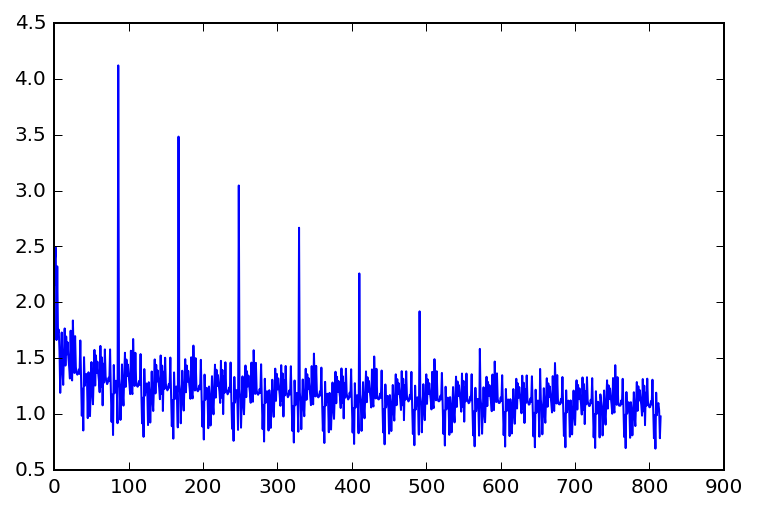

In [424]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(range(len(loss_track)), loss_track)


In [423]:

predictions, actuals = [], []
batch_size = 120
fd_keys = [encoder_inputs, decoder_inputs, decoder_targets]
try:
    #batch_n = 0
    print "training has begun..."  
    for en_batch, fr_batch in batch_source_target(test_en, test_fr, batch_size):
        feed_dict = make_feed_dict(fd_keys, en_batch, fr_batch)
        predict_ = sess.run(decoder_prediction, feed_dict)
        for i, (inp, act, pred) in enumerate(zip(feed_dict[encoder_inputs].T,
                                                 feed_dict[decoder_targets].T,
                                                 predict_.T)):
            actuals.append([remove_EOS_PAD(act)])
            predictions.append(remove_EOS_PAD(pred))
    BLEU4 = bleu_score.corpus_bleu(actuals, predictions, weights=(0.25, 0.25, 0.25, 0.25))
    BLEU2 = bleu_score.corpus_bleu(actuals, predictions, weights=(0.5, 0.5))
    print('Testing is complete, with a Corpus BLEU4 score of {} and BLEU2 of {}'.format(BLEU4*100, BLEU2*100))
except KeyboardInterrupt:
    print('training interrupted')


training has begun...
Testing is complete, with a Corpus BLEU4 score of 6.14085265141 and BLEU2 of 24.7941397871


Observations:
The above code generates a model with an increased BLEU score when it is trained on more data. Now I need to refactor the code so it is more original, efficient and generalisable.
- Simplify the generator batch stuff
- Go through and change all variable names referring to en and fr and source and target instead
- Make it so it's not an interactive session
- Sort phrases by length. Create batches of similar length. Randomise batches.
- Translated language stats should be similar to target. Compare percent of text covered by vocab words (i.e. is `<UNK>` being overused?)

In [ ]:
"""
def unknown_word_replacer(tokenized_text, vocab_size, lang='English'):
    ''' CURRENTLY UNUSED: This is the same as replace_with_word_id below 
    but without replacing tokens with ids.
    We take the list of lists, find FreqDist, replace any
    out of vocabulary words with <UNK>, return new list of lists'''
    flat = [item for sublist in tokenized_text for item in sublist]
    freq = nltk.FreqDist(flat)
    print "{} vocab size restricts to {} percent of total vocab.".format(lang, 100*(float(vocab_size)/len(set(flat))))
    vocab = dict(freq.most_common(vocab_size))
    text = []
    for sentence in tokenized_text:
        new_sent = []
        for token in sentence:
            if token not in vocab.keys():
                new_sent.append(u'<UNK>')
            else:
                new_sent.append(token)
        text.append(new_sent)
    return text, vocab
"""